# Transformer로 번역기 만들기 [프로젝트]

### 루브릭
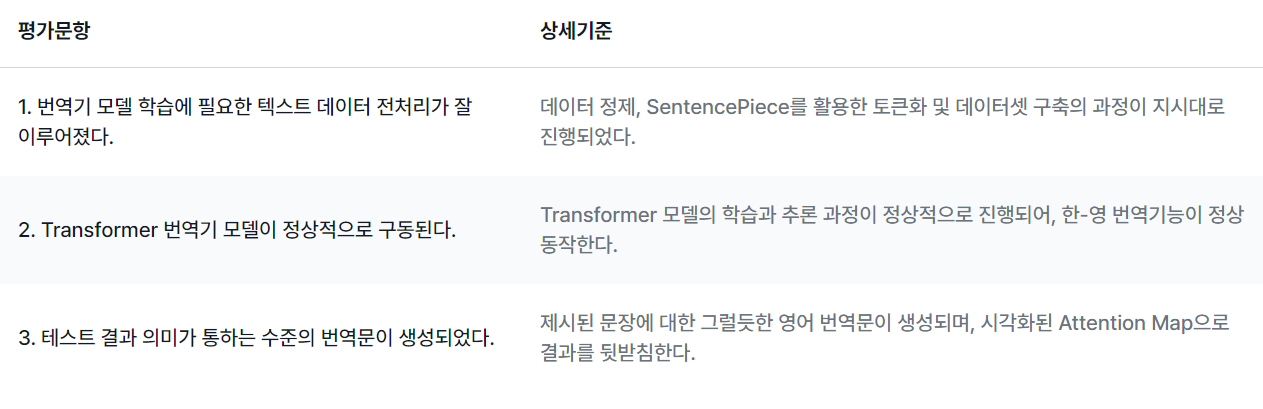

## 1. 텍스트 데이터 전처리
- 한국어 영어에 대한 전처리를 진행 (중복제거, 한영문자 빼고 삭제 등)
- sentencepiece로 토큰을 나눠주었다 
- 토큰길이는 50이하로 설정했다
- 총 51000개 정도의 데이터를 얻었다.
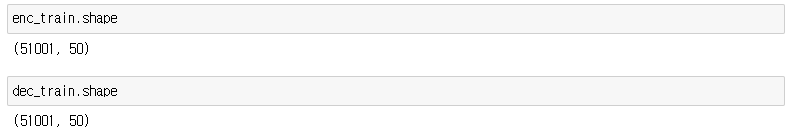

## 2. Transformer 정상 구동
- Loss가 계속해서 줄어들고있긴하지만 시간내에는 충분한 학습을 시킬수는 없을것같다
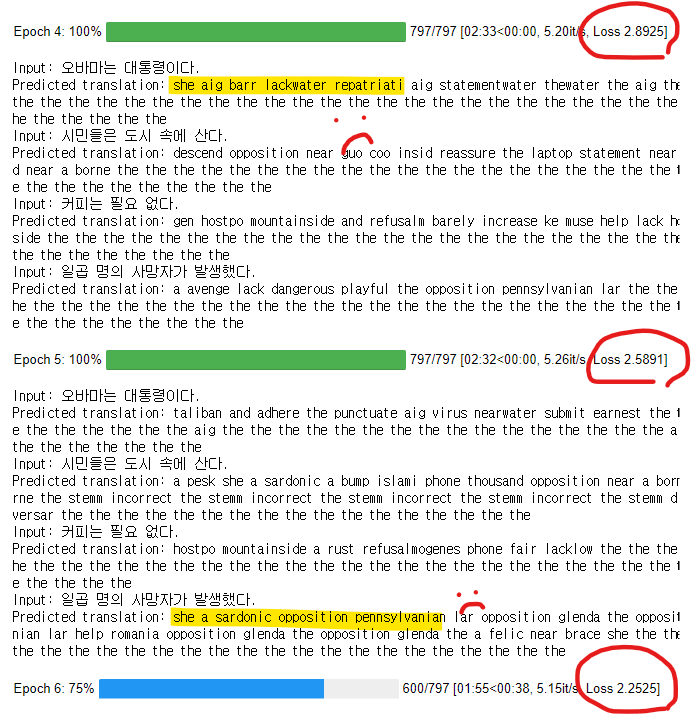

- Loss

## 3. 의미가 통하는 수준의 번역문이 생성 (Attention Map)
- 아직 학습을 완료하지못했다. 



## 회고 
- 1023 어제는 오류로 인해서 프로젝트를 마무리못함, 아침에 시간이 주어져서 해결함
- 오류는 mask를 만들때 input의 문제
    - 아래는 어제 겪은 오류에 대한 자세한 이야기가 적혀있습니다
- 하나하나 코드를 치려고 해보니 내가 생각하지 못한 디테일이 많아서 놀랐습니다.
- 모두 함수로 묶여있다보니 중간중간 결과가 잘나오는지를 확인하고싶은데 그게 어려웠습니다.
    - 혹시 방법이 있을까?
- 시간이 모자라서 학습을 완료하지는 못했지만 학습이 돌아간것만으로 기쁘다.. 
- 마스킹의 input이 의미하는지가 무엇인지 확인해보자
- evl를 train스텝마다 보여지는 코드를 잘 뜯어보자


## 오류

## 결합함수 오류 (함수 작성 방법 오류)

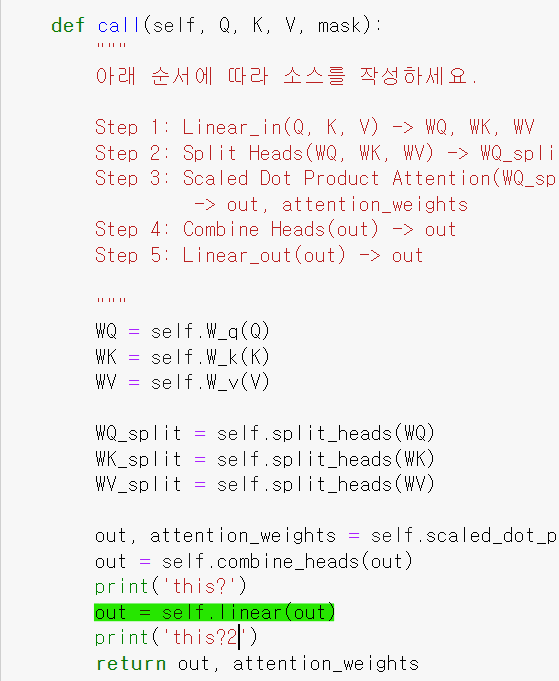
- 여기서 linear층에 tensor가 아닌게 들어간다고 오류가 계속 뜸
- 대충 이런 내용
```
raise TypeError('Inputs to a layer should be tensors. Got: %s' % (x,))
TypeError: Inputs to a layer should be tensors. Got: None
```

```
after dot product :  <class 'tensorflow.python.framework.ops.Tensor'>
after combine :  <class 'NoneType'>
```

- combine_head 함수 이후에 갑자기 type이 NoneType으로 변경이된다

- **return combined_x**
    - 함수끝에 이걸 안써줬었다..
    
## 마스킹 오류 (input  오류)
- 몇번은 잘돌아가다가 중간에 멈춘다. 왜인지 이유를 찾지못하고 끝났다
- enc_dec 패딩을 추가하는 방법에서 오류가난다
- 아래와 같은 오류가 났었다
```
InvalidArgumentError: required broadcastable shapes [Op:AddV2]
```
- **아래 코드에서 input을 src대신 tgt를 넣었을때 오류가 발생한다**
```
dec_enc_mask = generate_padding_mask(src)
```


#### 아래는 마스크에 관한 분석
```python
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# 여기 코잘마스크를 만드는 부분이 노드가 다르다

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

# 읽기 모드의 코잘마스크 만드는 부분에서 오류가 난다.. 왜인지 모르곘다

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

# 위에서처럼 tf.linalg.band_part로 마스크를 만들어주는데 여기서 오류가난다


def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)
    
    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)
    
    dec_enc_mask = generate_padding_mask(tgt)

    return enc_mask, dec_enc_mask, dec_mask
```

- 결과가 이게맞나? - 실제 데이터를 넣었더니 뒤쪽 padding이 제각각이라 깔끔하게 나오지않는것을 발견
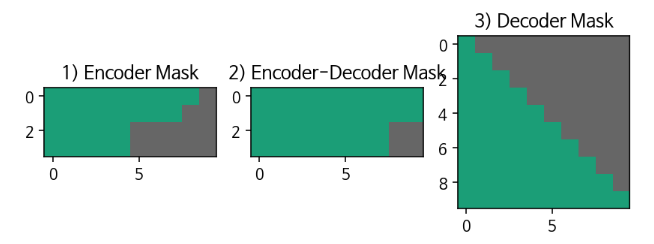



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import sentencepiece as spm
import tempfile

import seaborn # Attention 시각화를 위해 필요!


# 데이터 처리

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/AIFFEL_quest_rs/GoingDeeper/GD05/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

with open(kor_path, "r") as f: kor = f.read().splitlines()
with open(eng_path, "r") as f: eng = f.read().splitlines()
assert len(kor) == len(eng)

cleaned_corpus = list(set(zip(kor, eng)))

In [4]:
cleaned_corpus[2][1]

'have descended on her Atlanta house.'

In [5]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)


    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [6]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

In [ ]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # 임시 파일을 사용해 SentencePiece 학습
    with tempfile.NamedTemporaryFile(delete=False, mode='w', encoding='utf-8') as temp_file:
        for sentence in corpus:
            temp_file.write(sentence + "\n")
        temp_file_path = temp_file.name

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.train(
        input=temp_file_path,
        model_prefix=f"tk_model/{lang}_tokenizer",
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
        unk_id=unk_id
    )
    # model_type="unigram"
    # SentencePiece 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.load(f"tk_model/{lang}_tokenizer.model")

    return tokenizer
    

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

# 토크나이저 예시 사용


print("한국어 예시:", ko_tokenizer.encode_as_pieces("안녕하세요, 박형철입니다! ㅋㅋㅋㅋ"))
print("영어 예시:", en_tokenizer.encode_as_pieces("Hello, I'm HyoungChul! :) loll ~~"))

In [8]:
kor_corpus[1]

'그래서 미국 가정에는 일용품 수요가 발생할 것이고 , 미국 기업은 구매를 창출하고 상품 유통을 끌어내어 , 근로자 임금을 지불할 수 있을 것입니다 .'

In [9]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

max_length = 50

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    kor_tk_corpus = ko_tokenizer.encode(kor_corpus[idx])
    eng_tk_corpus = ko_tokenizer.encode(eng_corpus[idx])
    
    # 한국어만 50개 이하로 설정하면 7만개정도의 데이터, 둘다 설정하면 4만개정도가 나온다
    if len(kor_tk_corpus) < max_length+1 and len(eng_tk_corpus) < max_length+1:
        src_corpus.append(kor_tk_corpus)
        tgt_corpus.append(eng_tk_corpus)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [10]:
enc_train.shape

(51001, 50)

In [11]:
dec_train.shape

(51001, 50)

# 모델 설계

In [12]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)
            
        if mask is not None: 
            scaled_qk += (mask * -1e9)   

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x heads x length x self.depth ]
        """
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))
        return combined_x

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_split = self.split_heads(WQ)
        WK_split = self.split_heads(WK)
        WV_split = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_split, WK_split, WV_split,mask)
        out = self.combine_heads(out)
        out = self.linear(out)
        return out, attention_weights

In [14]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [15]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [16]:
# DecoderLayer 클래스를 작성하세요.
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, enc_dec_mask, padding_mask):
        """
        self MHA 
        """

        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual
        """
        cross MHA 
        """

        residual = out
        out = self.norm_2(x)
        out, enc_dec_attn = self.enc_dec_attn(out, enc_out, enc_out, enc_dec_mask)
        out = self.dropout(out)
        out += residual
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, enc_dec_attn

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns


In [19]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x emb ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= np.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [20]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [21]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [22]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff= 2048
src_vocab_size = 20000
tgt_vocab_size= 20000
pos_len= max_length
dropout=0.2
shared=True

transformer =Transformer(n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared=True)

In [23]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [25]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])
        
        variables = model.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [26]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [27]:

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [28]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [29]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_2562/1627634866.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/797 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: taliban aig virus campaign ripple the finalizveh the finalizveh the finalizveh the finalizveh the finalizveh the finalizveh the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 시민들은 도시 속에 산다.
Predicted translation: winds development brewer she help owe near best a sardonic a sardonic opposition near resist a rag a rag a sardonic a sardonic a sardonic opposition near resist a rag the the the the the the the the the the the the the the the the the the the the
Input: 커피는 필요 없다.
Predicted translation: ry islami council cast a rust the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: ry islamiry islami boyfriend and near a sardonic playful opposition near a sardonic playful the finalizveh the finalizveh the finalizveh the

  0%|          | 0/797 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: dangerous she provisionwater a brilliant viruswater the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 시민들은 도시 속에 산다.
Predicted translation: dangerous she winds statement kha production century a rust near best nov production statementclub opposition near a borne the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 커피는 필요 없다.
Predicted translation: m virus campaignkham best statementclub the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: thousand opposition near a borne statement nap help consideration the the the the the the the the the the the the the the the the the the the the 

  0%|          | 0/797 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: she aig viruswater aig statementwater the aig statementwater the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 시민들은 도시 속에 산다.
Predicted translation: ry production increase statement a borne should a demonstrat she the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 커피는 필요 없다.
Predicted translation: gen a rust near statement dissolv trimm virus ke territor taliban the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: gen thousand platt best and parklena tsunamitoff playful opposition pennsylvanian lar the the the the the the the the the the the the the the the the the the the

  0%|          | 0/797 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: she aig barr lackwater repatriati aig statementwater thewater the aig the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 시민들은 도시 속에 산다.
Predicted translation: descend opposition near guo coo insid reassure the laptop statement near a borne should near a borne the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 커피는 필요 없다.
Predicted translation: gen hostpo mountainside and refusalm barely increase ke muse help lack hostpo mountainside the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a avenge lack dangerous playful the opposition pennsylvanian lar the the the the the the the the the the the the the the the the the the the the th

  0%|          | 0/797 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: taliban and adhere the punctuate aig virus nearwater submit earnest the the the the the the the the the the the aig the the the the the the the the the the the the the the the the aig the the the the the the the the the the
Input: 시민들은 도시 속에 산다.
Predicted translation: a pesk she a sardonic a bump islami phone thousand opposition near a borne should a borne the stemm incorrect the stemm incorrect the stemm incorrect the stemm incorrect the stemm directions anniversar the the the the the the the the the the the the the the the the the
Input: 커피는 필요 없다.
Predicted translation: hostpo mountainside a rust refusalmogenes phone fair lacklow the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: she a sardonic opposition pennsylvanian lar opposition glenda the opposition pennsylvanian lar help romania opposition

  0%|          | 0/797 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: she aig virus andwater aig virus nearwater repatriati thewater the aig the the the the the the the the the the the the the the the thewater aig the the the the the the the the the the the the the the the the the the
Input: 시민들은 도시 속에 산다.
Predicted translation: she nov stra near a borne statement a bright tsunami breast the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 커피는 필요 없다.
Predicted translation: morse she barr ke lack hostpo mountainside the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: commission she a sardonic playful statement bundle phone romania the a sardonic opposition pennsylvanian lar the aopho she the near statement observ purveyor guse the a pennsylvanian

  0%|          | 0/797 [00:00<?, ?it/s]

KeyboardInterrupt: 